# Выполнил: Филоненко Никита Дмитриевич

-----

# **Домашнее задание 4 (pro): древесные алгоритмы**

### **Постановка задач**

### **Домашнее задание состоит из двух подзадач:**

**1. В  разделе 1 ваша задача:**
-  реализовать свое решающее дерево
- сравнить его со стандартной имплементацией из sklearn

Функции и классы дерева вы должны оформить в модуль `hw4_code_pro.py`.

**2. В разделе два ваша задача:** решить задачу бинарной классификации при помощи написанного Вами дерева, а также леса из sklearn, а после интерпретировать лучшие модели. Чуть точнее

- Извлечь данные из базы данных;
- Предобработать датасет;
- Обучить собственный класс DT, а также RF из `sklearn` в как базовом варианте (гиперпараметры по умолчанию), так и с подбором гиперпараметров;
- Интерпретировать алгоритмы при помощи LIME или SHAP.


### **Оценивание:**

- Как всегда оцениваются как код, так и ответы на вопросы. Если нет одного и/или другого, то часть баллов за соответствующее задание без колебаний снимается.
- Брать код из открытых источников позволительно. Следование культуре цитирования **обязательно.**
- Задание выполняется самостоятельно. «Похожие» решения считаются плагиатом и все задействованные студенты (в том числе те, у кого списали) не могут получить за него больше 0 баллов.
- Неэффективная реализация кода может негативно отразиться на оценке.

### **Формат сдачи:**
Задания сдаются через  anytask. Посылка должна содержать:
* Ноутбук в формате ipynb
* Модуль hw4_code_pro.py


### **Баллы:**

Суммарно за задание можно получить 10 основных баллов и 1 бонусный балло.

Оценка за ДЗ = min{ваш балл, 10}

Мягкий дедлайн: 2 февраля 23:59

**Продуктивной и интересной вам работы!**


In [3]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.tree import DecisionTreeClassifier
from matplotlib.colors import Colormap, ListedColormap
import pandas as pd
from sklearn.model_selection import train_test_split
import seaborn as sns
sns.set(style='whitegrid')

import psycopg2
import psycopg2.extras

import shap
import lime
import lime.lime_tabular

import optuna

import pickle

import warnings
warnings.filterwarnings('ignore')

# **1. Решающие деревья своими руками (6 баллов)**

В этой части вам нужно реализовать свой класс для обучения решающего дерева в задаче бинарной классификации с возможностью обработки вещественных и категориальных признаков.

Всего за часть вы можете получить 6 основных баллов и 1 бонусный.

### **Задание 1. (1 балл)**

Реализуйте функцию find_best_split из модуля hw4_code_pro.py

In [ ]:
from hw4_code_pro import find_best_split

### **Задание 2. (0.25 балла)**

Загрузите таблицу [students.csv](https://github.com/AnastasiyaMax/MLDS_ml_course_fall21/blob/main/hw/hw5_trees/students.csv). Это немного преобразованный датасет [User Knowledge](https://archive.ics.uci.edu/ml/datasets/User+Knowledge+Modeling).

В наборе данных:
- признаки объекта записаны в первых пяти столбцах;
- в последнем записана целевая переменная (класс: 0 или 1).

По этим данным, используя функцию из задания 1, постройте:
- пять кривых "порог — значение критерия Джини" для всех пяти признаков;
- scatter-графики "значение признака — класс" для всех пяти признаков;

In [ ]:
data = pd.read_csv("/data/students.csv", sep=",")

### **Задание 3. (0.6 балла)**

Проанализируйтте построенные кривые. Ответьте на поставленные вопросы:
- По какому признаку нужно производить деление выборки на два поддерева? (0.15 балла)
- Согласуется ли этот результат с визуальной оценкой scatter-графиков? (0.15 балла)
- Как бы охарактеризовали вид кривой для "хороших" признаков, по которым выборка делится почти идеально? (0.15 балла)
- Чем отличаются кривые для признаков, по которым деление практически невозможно? (0.15 балла)

**Ответ:**

### **Задание 4. (1.15 балла)**

В некоторых случаях необходимо анализировать код исполненного класса на предмет оптимальности и ошибок. Потренируйтесь в этом!

- Разберитесь с уже написанным кодом в классе DecisionTree модуля hw4_code_pro.py.
- Найдите ошибки в реализации метода \_fit_node.
- Напишите функцию \_predict_node.

**Примечание 1:**

Построение дерева осуществляется согласно базовому жадному алгоритму, предложенному в [лекции](https://github.com/esokolov/ml-course-hse/blob/master/2020-fall/lecture-notes/lecture07-trees.pdf) в разделе «Построение дерева».
- Для категориальных признаков выполняется преобразование, описанное в лекции в разделе «Учет категориальных признаков».

**Примечание 2:**

- Выбор лучшего разбиения необходимо производить по критерию Джини.
- Критерий останова: все объекты в листе относятся к одному классу или ни по одному признаку нельзя разбить выборку, чтобы Джини упал
- Ответ в листе: наиболее часто встречающийся класс в листе.


### **Задание 5. (0.5 балла)**

Протестируйте свое решающее дерево на датасете [mushrooms](https://archive.ics.uci.edu/ml/datasets/Mushroom). Для этого:

- Скачайте таблицу agaricus-lepiota.data (из [Data Folder](https://archive.ics.uci.edu/ml/machine-learning-databases/mushroom/))
- Прочитайте данные с помощью pandas
- Примените к каждому столбцу LabelEncoder (из sklearn), чтобы преобразовать строковые имена категорий в натуральные числа.
- Обучите решающее дерево на половине случайно выбранных объектов (признаки в датасете категориальные)
- Сделайте предсказания для оставшейся половины.
- Вычислите accuracy (так как мы используем эту метрику и в силу задачи, нам не очень важно, что будет классом 1, а что — классом 0).  


У вас должно получиться значение accuracy, равное единице (или очень близкое к единице), и не очень глубокое дерево.

In [ ]:
# Ваш код здесь


### **Задание 6. (бонус, 1 балл)**

Реализуйте в классе DecisionTree поддержку параметров max_depth, min_samples_split и min_samples_leaf по аналогии с DecisionTreeClassifier. Постройте графики зависимости качества предсказания в зависимости от этих параметров для набора данных tic-tac-toe (см. следующее задание).

### **Задание 7. (2 балла)**

**1. Загрузите следующие наборы данных** (напомним, что pandas умеет загружать файлы по url, в нашем случае это файл \*.data), предварительно ознакомившись с описанием признаков и целевой переменной в каждом из них (они записаны в Data Folder, в файле *.names):
* [mushrooms](https://archive.ics.uci.edu/ml/datasets/Mushroom) (загрузили в предыдущем пункте, классы записаны в нулевом столбце),
* [tic-tac-toe](https://archive.ics.uci.edu/ml/datasets/Tic-Tac-Toe+Endgame) (классы записаны в последнем столбце)
* [cars](https://archive.ics.uci.edu/ml/datasets/Car+Evaluation) (классы записаны в последнем столбце, считаем что unacc, acc — это класс 0, good, vgood — класс 1)
* [nursery](https://archive.ics.uci.edu/ml/datasets/Nursery) (классы записаны в последнем столбце, считаем, что not_recom и recommend — класс 0, very_recom, priority, spec_prior — класс 1).

**2. Закодируйте категориальные признаки, использовав LabelEncoder.** С помощью cross_val_score (cv=10) оцените accuracy на каждом из этих наборов данных следующих алгоритмов:
* DecisionTree, считающий все признаки вещественными
* DecisionTree, считающий все признаки категориальными
* DecisionTree, считающий все признаки вещественными + one-hot-encoding всех признаков
* DecisionTreeClassifier из sklearn. Запишите результат в pd.DataFrame (по строкам — наборы данных, по столбцам — алгоритмы).

**Рекомендации:**
* Чтобы cross_val_score вычисляла точность, нужно передать scoring=make_scorer(accuracy_score), обе фукнции из sklearn.metrics.
* Если вам позволяет память (а она скорее всего позволяет), указывайте параметр sparse=False в OneHotEncoder (если вы, конечно, используете его). Иначе вам придется добиваться того, чтобы ваша реализация дерева умела работать с разреженными матрицами.

In [ ]:
# Ваш код здесьﾟ


### **Задание 8. (0.5 балла)**

Проанализируйте результаты эксперимента. Ответьте на вопросы:
- Одинаково ли для разных наборов данных ранжируются алгоритмы?
Порассуждайте, почему так происходит.
- Обратите внимание на значение признаков в разных наборах данных.
Присутствует ли в результатах какая-то компонента случайности?
- Если случайность есть, то можно ли повлиять на нее и улушить работу алгоритмов?

**Ответ:**

# **2. Задача бинарной классификации реализованным деревом (4 балла)**

Всего за эту часть можно получить 4 балла.

В этом разделе вам необходимо решить задачу бинарной классификации самописным деревом и лесом из sklearn, а после интерпретировать лучшие модели. А именно:

- Извлечь данные из базы данных;
- Предобработать датасет;
- Обучить собственный класс DT и RF из `sklearn` в как базовом варианте (гиперпараметры по умолчанию), так и с подбором гиперпараметров;
- Интерпретировать алгоритмы при помощи LIME или SHAP.


### **Познакомимся с задачей: постановка**

У вас есть данные о полетах, обладающие следущими характеристиками:
- Для **каждого** клиента известна краткая информация о самом человеке, о типе билета и о рейсе, а также оценки клиента различным аспектам полета.
- Для **некоторых** клиентов известна их удовлетворенность полетом (satisfied или neutral or dissatisfied).

По данным необходимо обучить модель, предсказывающую удовлетворенность клиентов полетом. Итоговые предсказания нужно сделать для клиентов, **для которых ответ неизвестен.**

### **Получение данных:**

Компания держит все данные в облаке Яндекса в Postgresql. Данные разбиты на смысловые таблицы. Чтобы получить данные, вам необходимо подключиться к базе данных и добыть оттуда данные.

In [ ]:
!mkdir -p ~/.postgresql && \
wget "https://storage.yandexcloud.net/cloud-certs/CA.pem" \
    --output-document ~/.postgresql/root.crt && \
chmod 0600 ~/.postgresql/root.crt

### **Задание 9. Получение данных (0.5 балла)**

- Подключитесь к БД при помощи `psycopg2.connect()`
- Напишите SQL-запрос, объединяющий 3 нужные таблицы в одну
- Результат запроса поместите в `pd.DataFrame`. Индексом получившегося датафрейма сделайте столбец 'id'.

Список столбцов таблиц добудьте самостоятельно.


**Примечание:**
 Не забудьте закрыть соединение. Или открывайте соединение, используя менеджер контекста `with as`, который закроет его автоматически

##### **Параметры соединения:**
```
host=rc1b-70q90cunwkzx49mj.mdb.yandexcloud.net
port=6432
sslmode=verify-full
dbname=db_flights
user=mlhs_student
password=mlhs_student
target_session_attrs=read-write```
```

##### **Схема БД**

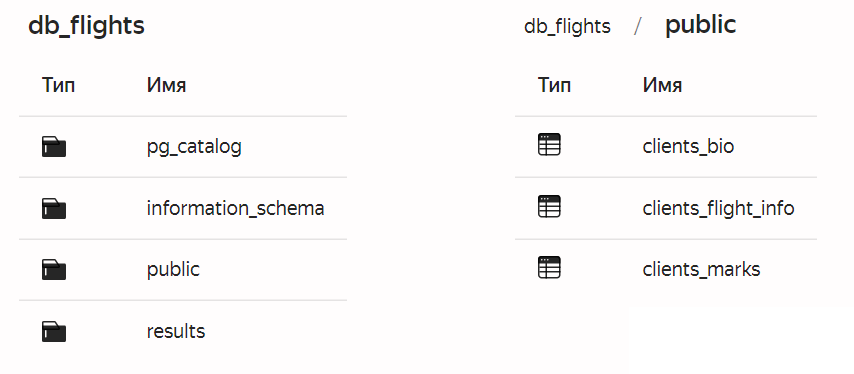

In [ ]:
# Ваш код здесь

In [ ]:
assert df.shape == (129_549, 23)

Разобьем датасет на тренировочную и тестовую части. Тестовую часть отложим надолго -- до самого конца этого ноутбука.

In [ ]:
df_train = df[df.satisfaction != '-']

df_train.head()

In [ ]:
assert df_train.shape == (103_644, 23)

In [ ]:
df_test = df[df.satisfaction == '-'].drop('satisfaction', axis=1)
df_test.head()

In [ ]:
assert df_test.shape == (25_905, 22)

Разбиваем данные на трейн и валидацию. Не меняйте сид.

In [ ]:
X_train, X_val, y_train, y_val = train_test_split(df_train.drop('satisfaction', axis=1), df_train.satisfaction, test_size=0.3, random_state=42)

In [ ]:
assert X_train.shape == (72_550, 22)
assert X_val.shape == (31_094, 22)

### **Задание 10 (0.25 балла)**

- Преобразуйте числовые столбцы в `float`. Проверьте, есть ли в датафрейме пропуски и выбросы (в том числе в категориальных признаках)
- Заполните пропуски в данных наиболее часто встречающимся значением.
Помните про правильность заполнения.
- Выведите основные статистики по числовым и категориальным столбцам таблицы
- Сделайте **текстовый** вывод о распределениях значений признаков

In [ ]:
# Ваш код здесь

`Ваш ответ здесь`

### **Задание 11. (2 балла)**

Осуществите предобработку датасета для обучения **полностью самостоятельно**, на основе вашего опыта из прошлых дз и изученной теории. Обязательно **комментируйте** каждое действие.

**Примечание:**

В данном задании ваша задача в том числе убедить ревьюера в достаточности предобработки.

In [ ]:
# Ваш код здесь

### **Задание 12. (0.25 балла)**

- Обучите самописное дерево и Random Forest с базовыми гиперпараметрами. Выведите `f1-score`.

In [ ]:
# Ваш код здесь

### **Задание 13. (0.4 баллa)**

- Попробуйте подобрать оптимальные гиперпараметры леса и дерева (если реализовали их в бонусе), используя [RandomizedSearchCV](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.RandomizedSearchCV.html).
- Сравните качество полученных моделей и выберите лучшую. Лучшую модель сохраните в pickle.

**Важно:**  

Хотя бы один из гиперпараметров перебирайте из распределения (например, `uniform` из `scipy.stats`)

In [ ]:
# Ваш код здесь

### **Задание 14. Анализ моделей (0.1 балла)**

- Отобразите`feature_importances_` вашего лучшего случайного леса;
- Проанализируйте, какие признаки оказались важными?

In [ ]:
# Ваш код здесь

`Ваш ответ здесь. `

### **Задание 15. (0.25 балла)**
- Интерпретируйте важности признаков с помощью SHAP.
- Опишите полученый график

**Важно:** Для подсчета используйте 1000 случайных объектов, иначе не дождетесь за приемлемое время

**Вам может помочь:** [Статья "Интерпретация моделей и диагностика сдвига данных: LIME, SHAP и Shapley Flow"](https://habr.com/ru/company/ods/blog/599573/) из блога ods.ai на Хабре

In [ ]:
# Ваш код здесь

`Ваш ответ здесь. `

### **Задание 16. (0.25 балла)**

- Интерпретируйте важности признаков для одного прогноза с помощью LIME;
- Опишите полученный график для выбранного наблюдения

In [ ]:
# Ваш код здесь

`Ваш ответ здесь. `

## Котобонус!

0.25 балла

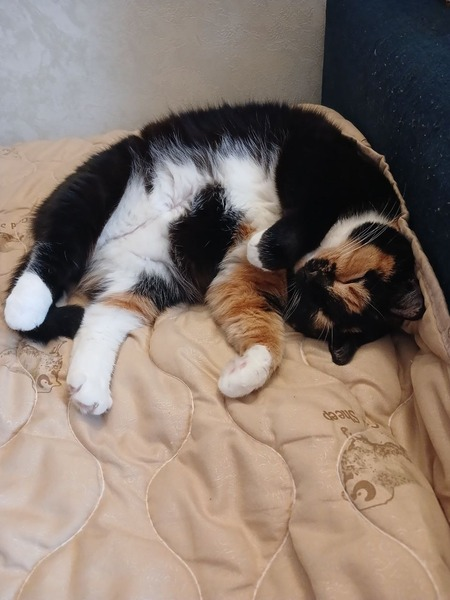

# Обратная связь

Расскажите, как вам это домашнее задание. Было ли оно полезным? Научились ли вы чему то? Насколько сложным по 10-балльной шкале оно вам показалось? Сколько времени у вас ушло на его выполнение? Что следовало ещё в него включить? Было ли что-то лишнее?